# Processing GOES-16 data with Dask & AWS Fargate

This notebook demonstrates how to work with the GOES-16 rainfall rate product available as part of the AWS Public Dataset Program (https://registry.opendata.aws/noaa-goes/).

## Python Imports

In [1]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
from dask.distributed import performance_report
from dask.distributed import Client

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

## Scale out Dask Workers

In [2]:
ecs = boto3.client('ecs')
resp = ecs.list_clusters()
clusters = resp['clusterArns']
if len(clusters) > 1:
    print("Please manually select your cluster")
cluster = clusters[0]
cluster

'arn:aws:ecs:us-east-1:816257832715:cluster/era5-Fargate-Dask-Cluster'

In [3]:
numWorkers=50
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])

# Set up the Dask Client to talk to our Fargate Dask Distributed Cluster

In [4]:
client = Client('Dask-Scheduler.local-dask:8786')
client

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/client.py:1130: VersionMismatchWarning: Mismatched versions found

+---------+----------------+---------------+---------------+
| Package | client         | scheduler     | workers       |
+---------+----------------+---------------+---------------+
| python  | 3.6.10.final.0 | 3.7.4.final.0 | 3.7.4.final.0 |
+---------+----------------+---------------+---------------+
Notes: 
-  python: Variation is sometimes ok, sometimes not. It depends on your workloads
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 50 Cores: 50 Memory: 350.00 GB


## Open an Example File and Check the Native Chunking

We want to chunk in a similar way for maximum performance

In [5]:
url = 's3://noaa-goes16/ABI-L2-RRQPEF/2020/181/19/OR_ABI-L2-RRQPEF-M6_G16_s20201811900207_e20201811909515_c20201811910042.nc'
ncfile = fsspec.open(url)
ds = xr.open_dataset(ncfile.open())

ds.RRQPE.encoding

{'chunksizes': (226, 226),
 'fletcher32': False,
 'shuffle': False,
 'zlib': True,
 'complevel': 1,
 'source': <File-like object S3FileSystem, noaa-goes16/ABI-L2-RRQPEF/2020/181/19/OR_ABI-L2-RRQPEF-M6_G16_s20201811900207_e20201811909515_c20201811910042.nc>,
 'original_shape': (5424, 5424),
 'dtype': dtype('int16'),
 '_Unsigned': 'true',
 '_FillValue': array([65535], dtype=uint16),
 'scale_factor': array([0.00152602], dtype=float32),
 'add_offset': array([0.], dtype=float32),
 'coordinates': 'latitude retrieval_local_zenith_angle quantitative_local_zenith_angle solar_zenith_angle t y x'}

## Open all the data for Julian days starting with 17* from 2020 as a single dataset

In [7]:
%%time

s3 = boto3.client("s3")
paginator = s3.get_paginator('list_objects_v2')
page_iterator = paginator.paginate(Bucket = 'noaa-goes16', Prefix = 'ABI-L2-RRQPEF/2020/')

@dask.delayed
def s3open_data(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    f = fs.open(path)
    ds = xr.open_dataset(f) 
    return ds['RRQPE'].values


files_mapper = [s3open_data("s3://noaa-goes16/" + file['Key']) for page in page_iterator for file in page['Contents']]

CPU times: user 5.85 s, sys: 37.9 ms, total: 5.89 s
Wall time: 8.61 s


In [8]:
# how many files did we load?

len(files_mapper)

29228

In [10]:
%%time
shape = ds.RRQPE.shape
dtype = ds.RRQPE.dtype
data_mapper = [dask.array.from_delayed(f, shape, dtype=dtype) for f in files_mapper]
all_data = dask.array.stack(data_mapper)
all_data

CPU times: user 4.56 s, sys: 30.5 ms, total: 4.59 s
Wall time: 4.62 s


,Array,Chunk
Bytes,3.44 TB,117.68 MB
Shape,"(29228, 5424, 5424)","(1, 5424, 5424)"
Count,87684 Tasks,29228 Chunks
Type,float32,numpy.ndarray


In [12]:
%%time 

with performance_report(filename="dask-report.html"):
    all_data_sum = dask.array.nansum(all_data, axis=0).compute()

CPU times: user 1min 3s, sys: 832 ms, total: 1min 4s
Wall time: 12min 58s


## Convert units to mm/h to mm

In [13]:
all_data_sum = all_data_sum * (1.0 / 6.0)

### Plot Average Surface Temperature

Text(0.5, 1.0, 'Precipitation Accumulation 2020 YTD')

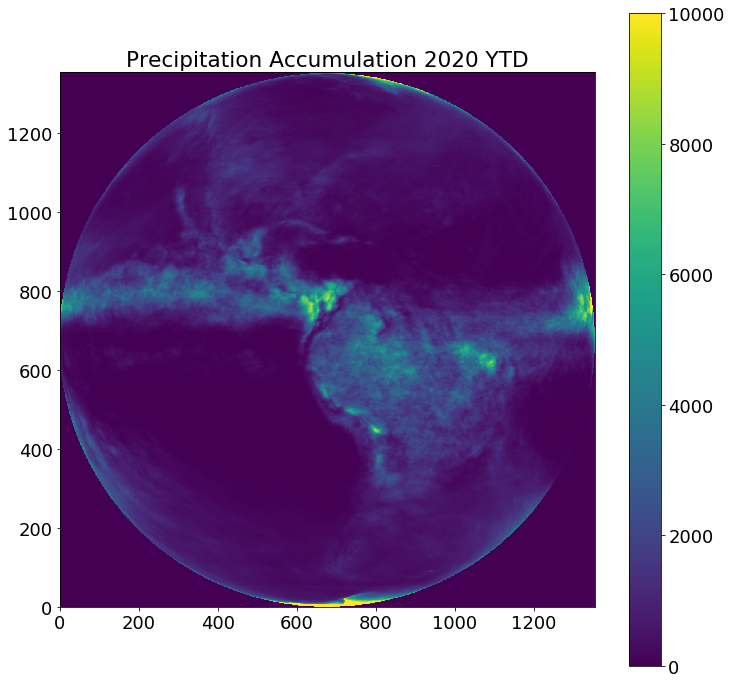

In [14]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'aspect': 'equal'})
pc = ax.pcolormesh(all_data_sum[::-4, ::4])
plt.colorbar(pc)
pc.set_clim([0, 10000])
plt.title('Precipitation Accumulation 2020 YTD')

## Cluster scale down

When we are temporarily done with the cluster we can scale it down to save on costs

In [ ]:
numWorkers=0
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])